# Evaluación Cuantitativa de Explicabilidad con Quantus

Este notebook evalúa cuantitativamente la calidad de las explicaciones XAI usando la librería Quantus.

**Métricas evaluadas:**
- **Fidelidad (Faithfulness)**: Faithfulness Correlation - mide si la explicación refleja el comportamiento interno del modelo.
- **Robustez (Robustness)**: Average Sensitivity - evalúa la estabilidad ante perturbaciones leves.
- **Complejidad (Complexity)**: Entropy/Complexity - estima la simplicidad de la explicación.
- **Aleatorización (Model Parameter Randomisation Test, MPRT)**: Evalúa si las explicaciones dependen solo del modelo entrenado o si podrían generarse de forma similar con un modelo aleatorio.
- **Localización (Localization)**: Region Perturbation - determina la precisión espacial.

**Métodos XAI evaluados:**
- Grad-CAM
- Grad-CAM++
- Integrated Gradients
- Saliency Maps

**Nota:** Este notebook evalúa los 3 modelos individuales (`blood`, `retina`, `breast`) y genera gráficos radar comparativos a partir de los ficheros JSON producidos por `quantus_evaluation.py`.

Comprobación de GPU (ejecutado originalmente):

```python
import torch
torch.cuda.is_available(), torch.cuda.get_device_name(0)

```

In [1]:
import sys
print(sys.executable)

/opt/py310/bin/python


In [2]:
import sys, numpy as np
print(sys.executable)
print(np.__version__)

/opt/py310/bin/python
1.26.4


In [3]:
# Configuración inicial

import os
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from math import pi

# Definir ruta absoluta del proyecto
PROJECT_DIR = Path("/home/TFM_Laura_Monne").resolve()

assert PROJECT_DIR.exists(), f"No existe el directorio del proyecto: {PROJECT_DIR}"

# Configuración de rutas
OUTPUTS_DIR = PROJECT_DIR / "outputs"
OUTPUTS_DIR.mkdir(exist_ok=True)

# Lista de datasets que vamos a usar
datasets = ["blood", "retina", "breast"]

print(f"Directorio de outputs: {OUTPUTS_DIR}")


Directorio de outputs: /workspace/TFM_Laura_Monne/outputs


In [4]:
# Carga de resultados Quantus para los 3 datasets

results_by_dataset = {}
metadata_rows = []

for dataset in datasets:
    json_path = OUTPUTS_DIR / f"quantus_metrics_{dataset}.json"
    if json_path.exists():
        with open(json_path, "r") as f:
            results_by_dataset[dataset] = json.load(f)
        print(f"✅ Cargado: {dataset} ({json_path.name})")

        meta = results_by_dataset[dataset].get("metadata", {})
        metadata_rows.append({
            "Dataset": dataset.upper(),
            "Num samples": meta.get("num_samples"),
            "Sample strategy": meta.get("sample_strategy"),
            "Seed": meta.get("seed"),
            "Target": meta.get("target"),
            "Métodos": ", ".join(meta.get("methods", [])) if meta else None,
        })
    else:
        print(f"⚠️  No encontrado: {json_path.name}")
        print("   Ejecuta `python quantus_evaluation.py --dataset", dataset, "...` antes de usar este notebook.")

if not results_by_dataset:
    raise ValueError("❌ No se encontraron resultados Quantus. Genera primero los ficheros JSON con quantus_evaluation.py.")

if metadata_rows:
    print("")
    print("Resumen de metadata (leída de JSON):")
    display(pd.DataFrame(metadata_rows))


✅ Cargado: blood (quantus_metrics_blood.json)
✅ Cargado: retina (quantus_metrics_retina.json)
✅ Cargado: breast (quantus_metrics_breast.json)

Resumen de metadata (leída de JSON):


,Dataset,Num samples,Sample strategy,Seed,Target,Métodos
0,BLOOD,100,reservoir,42,pred,"gradcam, gradcampp, integrated_gradients, sali..."
1,RETINA,100,reservoir,42,pred,"gradcam, gradcampp, integrated_gradients, sali..."
2,BREAST,100,reservoir,42,pred,"gradcam, gradcampp, integrated_gradients, sali..."


In [5]:
from math import pi

# Lista de datasets que vamos a usar (por claridad)
datasets = ["blood", "retina", "breast"]

# Métricas a mostrar en los radares (orden como en el tutorial de Quantus)
# Orden: Faithfulness (top), Localisation, Complexity, Randomisation, Robustness (clockwise)
metric_names = ["faithfulness", "localization", "complexity", "randomization", "robustness"]
metric_labels = ["Faithfulness", "Localisation", "Complexity", "Randomisation", "Robustness"]

# Métodos XAI
methods = ["gradcam", "gradcampp", "integrated_gradients", "saliency"]
method_labels = {
    "gradcam": "Grad-CAM",
    "gradcampp": "Grad-CAM++",
    "integrated_gradients": "Integrated Gradients",
    "saliency": "Saliency",
}

# Paleta tipo Quantus
method_colors = {
    "gradcam": "#1b9e77",   # teal
    "gradcampp": "#d95f02", # orange
    "integrated_gradients": "#1f77b4", # blue
    "saliency": "#d62728",  # red
}

# Estilo del radar: "quantus_rank" (como tutorial) o "scaled"
RADAR_STYLE = "quantus_rank"

# Normalización para RADAR_STYLE="scaled"
NORMALIZATION_MODE = "global_minmax"  # opciones: "auto", "global_minmax"

# Métricas donde "menos es mejor"
lower_is_better = {"robustness", "complexity", "randomization"}


In [6]:
def build_df_for_dataset(dataset_name: str, use_std: bool = False) -> pd.DataFrame:
    """Devuelve un DataFrame con las métricas de Quantus para un dataset concreto.

    - Filas: métodos XAI
    - Columnas: métricas
    - use_std: si True, devuelve desviación estándar en lugar de media
    """
    results = results_by_dataset[dataset_name]

    data = {m: [] for m in methods}
    for m in methods:
        if m not in results:
            continue
        for metric in metric_names:
            info = results[m].get(metric, None)
            if info is None:
                data[m].append(np.nan)
            else:
                val = info.get("std") if use_std else info.get("mean")
                data[m].append(float(val) if val is not None else np.nan)

    df = pd.DataFrame.from_dict(data, orient="index", columns=metric_names)
    return df


def build_all_df(use_std: bool = False) -> pd.DataFrame:
    """Concatena todas las tablas (dataset x método) en un único DataFrame con MultiIndex."""
    frames = []
    for ds in datasets:
        df = build_df_for_dataset(ds, use_std=use_std)
        df["Dataset"] = ds
        frames.append(df)
    df_all = pd.concat(frames).set_index("Dataset", append=True)
    df_all = df_all.reorder_levels([1, 0])  # (Dataset, Método)
    return df_all


def build_rank_df(df_mean: pd.DataFrame) -> pd.DataFrame:
    """Replica el enfoque del tutorial de Quantus: normaliza por max y rankea."""
    df = df_mean.abs()
    df_norm = df.copy()

    for metric in metric_names:
        if metric == "robustness":
            denom = df[metric].replace(0.0, np.nan)
            df_norm[metric] = df[metric].min() / denom
        else:
            mx = df[metric].max()
            df_norm[metric] = df[metric] / mx if mx else 0.0

    df_rank = df_norm.rank()
    return df_rank


In [7]:
# Normalización de métricas

def _within_bounds(series: pd.Series, lo: float, hi: float, tol: float = 1e-6) -> bool:
    s = series.dropna()
    if s.empty:
        return False
    return (s.min() >= lo - tol) and (s.max() <= hi + tol)


def compute_global_minmax() -> dict:
    df_all = build_all_df(use_std=False)
    stats = {}
    for metric in metric_names:
        col = df_all[metric].astype(float).values
        if np.all(np.isnan(col)):
            stats[metric] = (0.0, 1.0)
        else:
            stats[metric] = (np.nanmin(col), np.nanmax(col))
    return stats


global_minmax = compute_global_minmax()


def normalize_df(df: pd.DataFrame, mode: str = "auto") -> pd.DataFrame:
    """Normaliza métricas a [0,1].

    - mode="auto": usa límites conocidos si aplica; si no, usa min-max global.
    - mode="global_minmax": fuerza min-max global para todas.
    """
    df_norm = df.copy()

    for metric in metric_names:
        col = df[metric].astype(float)
        mn, mx = global_minmax.get(metric, (np.nanmin(col.values), np.nanmax(col.values)))
        denom = mx - mn

        if mode == "auto":
            if metric == "faithfulness" and _within_bounds(col, -1.0, 1.0):
                norm = (col + 1.0) / 2.0
            elif metric == "randomization" and _within_bounds(col, -1.0, 1.0):
                norm = 1.0 - (col + 1.0) / 2.0
            elif metric == "localization" and _within_bounds(col, 0.0, 1.0):
                norm = col
            elif metric in {"robustness", "complexity"}:
                norm = 1.0 / (1.0 + np.maximum(col, 0.0))
            else:
                if not np.isfinite(denom) or denom < 1e-12:
                    norm = pd.Series(0.5, index=col.index)
                else:
                    norm = (col - mn) / denom
                    if metric in lower_is_better:
                        norm = 1.0 - norm
        else:
            if not np.isfinite(denom) or denom < 1e-12:
                norm = pd.Series(0.5, index=col.index)
            else:
                norm = (col - mn) / denom
                if metric in lower_is_better:
                    norm = 1.0 - norm

        norm = norm.clip(0.0, 1.0)
        df_norm[metric] = norm.fillna(0.5)

    return df_norm

# Radar axes (tomado del tutorial de Quantus/Matplotlib)
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='polygon'):
    """Create a radar chart with `num_vars` axes."""
    theta = np.linspace(0, 2 * np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):
        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels, angles=None):
            self.set_thetagrids(angles=np.degrees(theta), labels=labels)

        def _gen_axes_patch(self):
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            if frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars, radius=.5, edgecolor="k")
            raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            if frame == 'polygon':
                spine = Spine(axes=self, spine_type='circle', path=Path.unit_regular_polygon(num_vars))
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5) + self.transAxes)
                return {'polar': spine}
            raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


In [8]:
def plot_radar_for_dataset(dataset_name: str):
    """Dibuja un gráfico radar para un dataset (blood/retina/breast)."""
    df_mean = build_df_for_dataset(dataset_name, use_std=False)
    df_std = build_df_for_dataset(dataset_name, use_std=True)

    print("")
    print(f"=== {dataset_name.upper()} - valores originales (media) ===")
    display(df_mean)
    print("")
    print(f"=== {dataset_name.upper()} - valores originales (std) ===")
    display(df_std)

    if RADAR_STYLE == "quantus_rank":
        df_plot = build_rank_df(df_mean)
        rgrid_max = int(np.nanmax(df_plot.values))
        rgrids = np.arange(1, rgrid_max + 1)
        rgrid_labels = []
        title_suffix = "rank"
    else:
        df_plot = normalize_df(df_mean, mode=NORMALIZATION_MODE)
        rgrids = [0.2, 0.4, 0.6, 0.8, 1.0]
        rgrid_labels = ["0.2", "0.4", "0.6", "0.8", "1.0"]
        title_suffix = NORMALIZATION_MODE

    print("")
    print(f"=== {dataset_name.upper()} - valores para radar ({RADAR_STYLE}) ===")
    display(df_plot)

    theta = radar_factory(len(metric_names), frame='polygon')
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(right=0.78)

    for method in df_plot.index:
        vals = df_plot.loc[method, metric_names].tolist()
        vals = [0.0 if (isinstance(v, (int, float)) and np.isnan(v)) else (0.0 if v is None else float(v)) for v in vals]
        ax.plot(theta, vals, label=method_labels.get(method, method), color=method_colors.get(method), linewidth=2)
        ax.fill(theta, vals, alpha=0.15, color=method_colors.get(method))

    ax.set_varlabels(labels=metric_labels)
    ax.set_rgrids(rgrids, labels=rgrid_labels)

    title = "Perfil de Métricas por Método XAI" + chr(10) + f"Dataset: {dataset_name.upper()} (radar={title_suffix})"
    ax.set_title(title, position=(0.5, 1.1), ha='center', fontsize=14)

    ax.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

    out_path = OUTPUTS_DIR / f"quantus_radar_{dataset_name}.png"
    fig.savefig(out_path, dpi=300, facecolor='white')
    print(f"✅ Figura guardada en: {out_path}")

    plt.show()
    plt.close()



=== BLOOD - valores originales (media) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,-0.036517,0.103267,11.485034,-0.189119,0.009762
gradcampp,-0.024925,0.103840,11.586908,-0.311158,0.007119
integrated_gradients,0.093734,0.383021,10.848085,0.115161,0.300540
saliency,0.018325,0.312754,10.853231,0.169354,0.268544



=== BLOOD - valores originales (std) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,0.218748,0.231444,0.164144,0.307175,0.004642
gradcampp,0.226495,0.233728,0.091051,0.277565,0.002765
integrated_gradients,0.205225,0.441303,0.189881,0.049752,0.050161
saliency,0.209916,0.417795,0.223541,0.026710,0.057170



=== BLOOD - valores para radar (quantus_rank) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,3.0,1.0,3.0,3.0,3.0
gradcampp,2.0,2.0,4.0,4.0,4.0
integrated_gradients,4.0,4.0,1.0,1.0,1.0
saliency,1.0,3.0,2.0,2.0,2.0


✅ Figura guardada en: /workspace/TFM_Laura_Monne/outputs/quantus_radar_blood.png


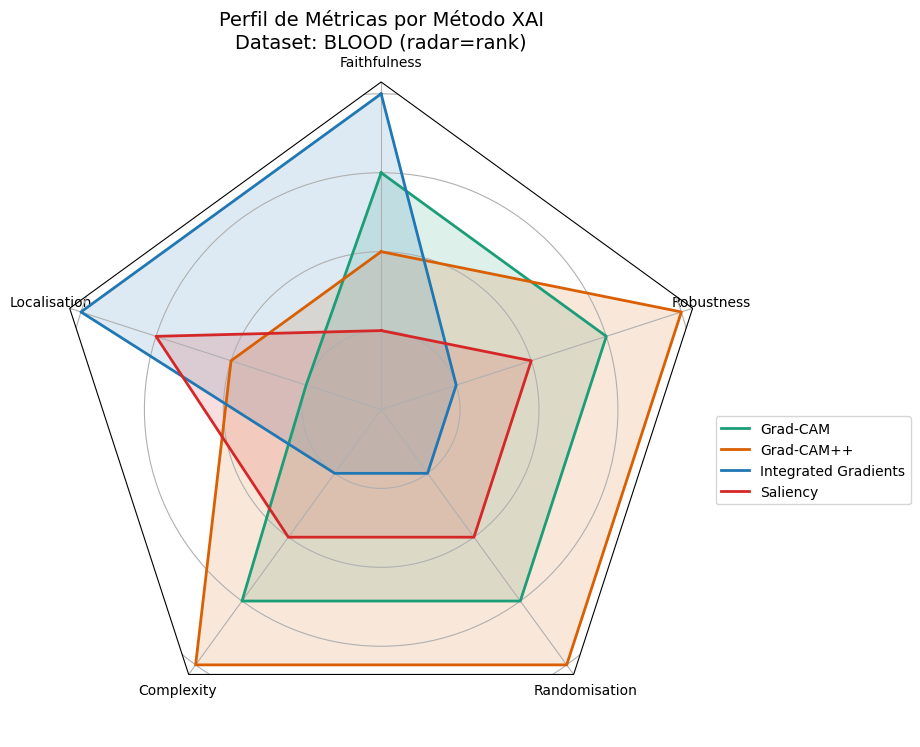


=== RETINA - valores originales (media) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,0.044370,0.141330,11.497535,-0.113153,0.130036
gradcampp,0.009026,0.125152,11.557496,-0.596424,0.089785
integrated_gradients,0.012085,0.210651,11.185185,0.225378,0.886973
saliency,-0.003336,0.155902,11.219311,0.129784,1.251057



=== RETINA - valores originales (std) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,0.220723,0.146288,0.135483,0.245270,0.046073
gradcampp,0.256963,0.162919,0.084959,0.216356,0.046414
integrated_gradients,0.174268,0.191598,0.139878,0.082414,0.050011
saliency,0.217833,0.171205,0.071748,0.014535,0.218966



=== RETINA - valores para radar (quantus_rank) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,4.0,2.0,3.0,1.0,3.0
gradcampp,2.0,1.0,4.0,4.0,4.0
integrated_gradients,3.0,4.0,1.0,3.0,2.0
saliency,1.0,3.0,2.0,2.0,1.0


✅ Figura guardada en: /workspace/TFM_Laura_Monne/outputs/quantus_radar_retina.png


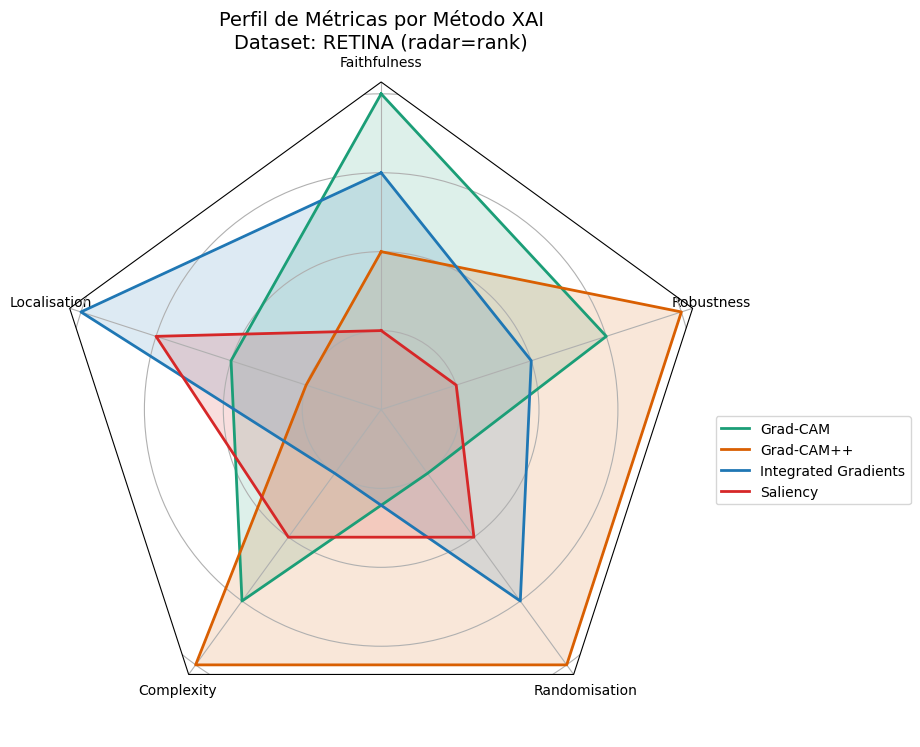


=== BREAST - valores originales (media) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,0.104958,0.116216,11.110408,-0.321516,0.283750
gradcampp,0.069209,0.117711,11.337744,-0.024103,0.211327
integrated_gradients,0.000050,0.121546,10.876305,0.313086,0.897906
saliency,0.080267,0.121331,11.007378,0.091867,1.032637



=== BREAST - valores originales (std) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,0.230484,0.460215,0.289243,0.188434,0.205257
gradcampp,0.207861,0.462311,0.209492,0.385336,0.136520
integrated_gradients,0.174013,0.472026,0.231678,0.057804,0.019328
saliency,0.179325,0.470340,0.186324,0.037412,0.135248



=== BREAST - valores para radar (quantus_rank) ===


,faithfulness,localization,complexity,randomization,robustness
gradcam,4.0,1.0,3.0,4.0,3.0
gradcampp,2.0,2.0,4.0,1.0,4.0
integrated_gradients,1.0,4.0,1.0,3.0,2.0
saliency,3.0,3.0,2.0,2.0,1.0


✅ Figura guardada en: /workspace/TFM_Laura_Monne/outputs/quantus_radar_breast.png


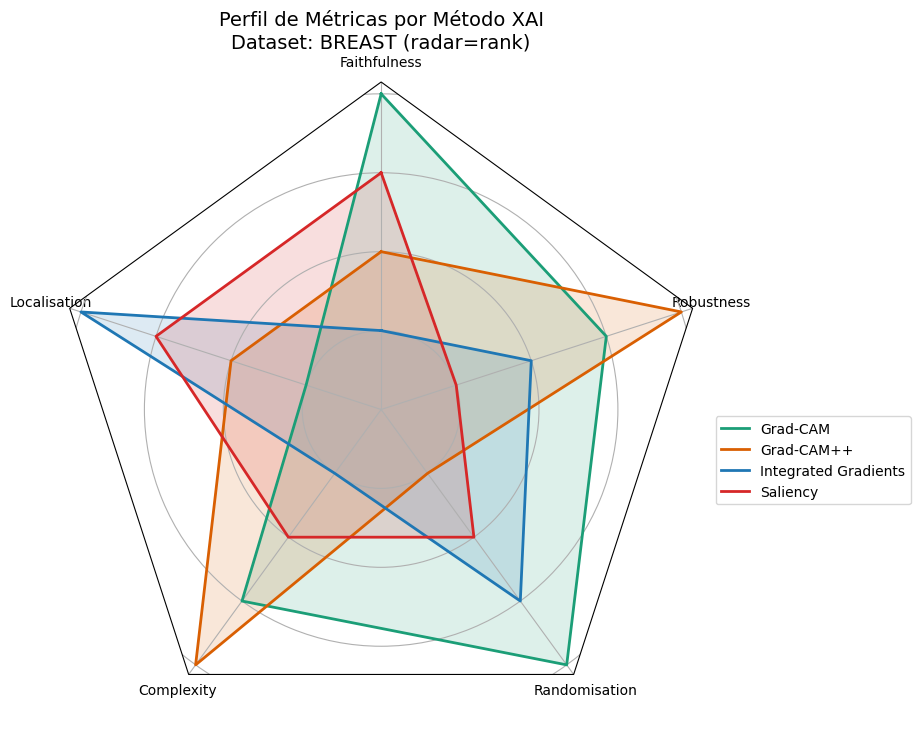

In [9]:
# Generar gráficos radar y mostrar tablas para cada dataset

for ds in datasets:
    plot_radar_for_dataset(ds)

# En este punto se generan las figuras:
# - outputs/quantus_radar_blood.png
# - outputs/quantus_radar_retina.png
# - outputs/quantus_radar_breast.png
# y se muestran en el notebook junto con las tablas de valores originales
# y normalizados.


In [10]:
# Guardado de tablas (valores originales, std y normalizados) por dataset

print("=== Guardando tablas por dataset en outputs/ ===")

for dataset in datasets:
    # Construir tablas
    df_raw = build_df_for_dataset(dataset, use_std=False)
    df_std = build_df_for_dataset(dataset, use_std=True)
    df_norm = normalize_df(df_raw, mode=NORMALIZATION_MODE)

    # Rutas de guardado
    raw_path = OUTPUTS_DIR / f"quantus_table_raw_{dataset}.csv"
    std_path = OUTPUTS_DIR / f"quantus_table_std_{dataset}.csv"
    norm_path = OUTPUTS_DIR / f"quantus_table_normalized_{dataset}.csv"

    # Guardar tablas
    df_raw.to_csv(raw_path, index=True)
    df_std.to_csv(std_path, index=True)
    df_norm.to_csv(norm_path, index=True)

    print(f"📁 Guardado: {raw_path.name}")
    print(f"📁 Guardado: {std_path.name}")
    print(f"📁 Guardado: {norm_path.name} (norm={NORMALIZATION_MODE})")


=== Guardando tablas por dataset en outputs/ ===
📁 Guardado: quantus_table_raw_blood.csv
📁 Guardado: quantus_table_std_blood.csv
📁 Guardado: quantus_table_normalized_blood.csv (norm=global_minmax)
📁 Guardado: quantus_table_raw_retina.csv
📁 Guardado: quantus_table_std_retina.csv
📁 Guardado: quantus_table_normalized_retina.csv (norm=global_minmax)
📁 Guardado: quantus_table_raw_breast.csv
📁 Guardado: quantus_table_std_breast.csv
📁 Guardado: quantus_table_normalized_breast.csv (norm=global_minmax)
